In [1]:
!pip install pyarrow scikeras tensorflow keras


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 

fp = "Dados_Jan1980_mar2020_interpolado.feather"
df = pd.read_feather(fp)

print("Shape:", df.shape)
print("\nColunas:\n", df.columns.tolist())
print("\nTipos de dados (dtypes):\n", df.dtypes)
display(df.head())
display(df.describe().T)

Shape: (324576, 12)

Colunas:
 ['year', 'month', 'lat', 'lon', 'temp850', 'press', 'shum850', 't2m', 'u500', 'u850', 'v850', 'prgpcp']

Tipos de dados (dtypes):
 year         int64
month        int64
lat        float64
lon        float64
temp850    float64
press      float64
shum850    float64
t2m        float64
u500       float64
u850       float64
v850       float64
prgpcp     float64
dtype: object


,year,month,lat,lon,temp850,press,shum850,t2m,u500,u850,v850,prgpcp
0,1980,1,-58.75,271.25,-2.65499,993.735,3.12400,4.96807,11.3675,6.60750,-0.915001,2.61009
1,1980,2,-58.75,271.25,-3.47750,995.384,2.92150,4.89802,10.6775,5.27499,-0.340000,3.24624
2,1980,3,-58.75,271.25,-4.87000,990.998,2.78050,3.88049,10.7350,6.76750,0.285000,3.96585
3,1980,4,-58.75,271.25,-4.39250,1006.920,2.71475,3.44575,7.9700,6.69250,2.377500,2.95227
4,1980,5,-58.75,271.25,-5.34500,993.502,2.73400,3.31403,4.4575,1.90750,-3.905000,3.26092


,count,mean,std,min,25%,50%,75%,max
year,324576.0,1999.627329,11.619673,1980.000000,1990.000000,2000.000000,2010.000000,2020.0000
month,324576.0,6.472050,3.460032,1.000000,3.000000,6.000000,9.000000,12.0000
lat,324576.0,-25.000000,20.194399,-58.750000,-41.875000,-25.000000,-8.125000,8.7500
lon,324576.0,300.000000,17.305493,271.250000,285.625000,300.000000,314.375000,328.7500
temp850,324576.0,10.554973,8.090447,-16.730000,3.980010,14.205000,17.142500,23.6843
press,324576.0,987.540499,49.126680,679.165000,983.888000,1003.330000,1013.350000,1037.7900
shum850,324576.0,6.797194,3.489327,0.747749,3.517630,6.179470,10.066025,18.6179
t2m,324576.0,17.032111,8.154114,-23.691700,10.473825,19.096500,24.251900,31.5931
u500,324576.0,6.927479,10.082489,-14.960000,-2.752500,8.187500,15.837500,30.6804
u850,324576.0,1.517694,6.799288,-14.162500,-3.859452,0.664997,7.427500,20.2250


In [3]:
# t2m como target
# temperatura do ar medida a 2 metros de altura (padrão meteorológico para representar a temperatura próxima à superfície)

target_col = "t2m"

if target_col not in df.columns:
    raise ValueError(f"Coluna alvo '{target_col}' não encontrada. Colunas disponíveis: {df.columns.tolist()} ")

print("Valores ausentes por coluna (top):")
print(df.isna().sum().sort_values(ascending=False).head(10))
display(df[[target_col]].describe().T)

Valores ausentes por coluna (top):
year       0
month      0
lat        0
lon        0
temp850    0
press      0
shum850    0
t2m        0
u500       0
u850       0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
t2m,324576.0,17.032111,8.154114,-23.6917,10.473825,19.0965,24.2519,31.5931



Correlação (valor absoluto) do alvo com outras variáveis:


t2m        1.000000
temp850    0.918917
lat        0.876533
u850      -0.808291
shum850    0.772315
u500      -0.766618
prgpcp     0.226086
v850      -0.221121
lon        0.102265
press      0.102184
month     -0.082597
year       0.009159
Name: t2m, dtype: float64

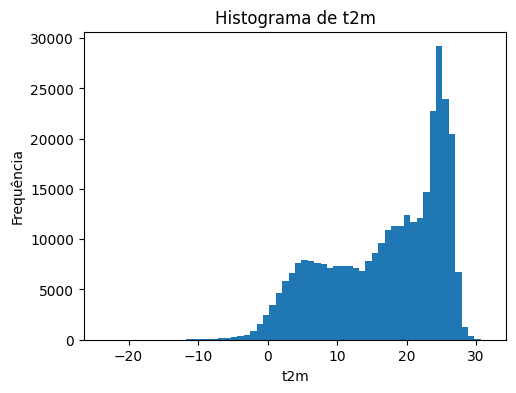

In [26]:
# 3.1 Distribuição da variável alvo (histograma + boxplot)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df[target_col].dropna(), bins=60)
plt.title(f"Histograma de {target_col}")
plt.xlabel(target_col)
plt.ylabel("Frequência")




# 3.2 Matriz de correlação (apenas numéricas) entre target e demais atributos

num_cols = df.select_dtypes(include="number").columns.tolist()
if target_col not in num_cols:
    print("Alvo não é numérico — verifique.")
else:
    corr = df[num_cols].corr()[target_col].sort_values(key=lambda x: x.abs(), ascending=False)
    print("\nCorrelação (valor absoluto) do alvo com outras variáveis:")
    display(corr.head(12))

In [5]:
k = 8
corr_vals = df[num_cols].corr()[target_col].abs().sort_values(ascending=False)
candidate_features = [c for c in corr_vals.index if c != target_col][:k]
print("Features candidatas selecionadas automaticamente:", candidate_features)

# Criar X e y, e remover linhas com NA nas colunas escolhidas
X = df[candidate_features].copy()
y = df[target_col].copy()
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)
print("Shape after drop NA:", X.shape, y.shape)

Features candidatas selecionadas automaticamente: ['temp850', 'lat', 'u850', 'shum850', 'u500', 'prgpcp', 'v850', 'lon']
Shape after drop NA: (324576, 8) (324576,)


In [6]:
# Ajuste o nome da coluna de tempo

time_col_candidates = [c for c in df.columns if "date" in c.lower() or "data" in c.lower() or "time" in c.lower()]
print("Possíveis colunas de tempo:", time_col_candidates)

# Se existir uma coluna temporal, reconstituir X e y ordenados; se não, assumimos que os dados já estão em ordem temporal.
time_col = time_col_candidates[0] if time_col_candidates else None
if time_col:
    df_tmp = df.loc[mask].sort_values(time_col).reset_index(drop=True)
    X = df_tmp[candidate_features]
    y = df_tmp[target_col]
    print("ordenado por", time_col)
else:
    print("Nenhuma coluna temporal detectada automaticamente. Verifique se os dados já estão ordenados.")

Possíveis colunas de tempo: []
Nenhuma coluna temporal detectada automaticamente. Verifique se os dados já estão ordenados.


In [7]:
# normalização dos dados
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

In [14]:
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers

def build_model(n_hidden=1, n_neurons=32, activation="tanh", dropout_rate = 0.0, learning_rate=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_scaled.shape[1],)))
    for i in range (n_neurons):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate and dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation="linear"))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
    return model

# Wrapper scikeras
keras_reg = KerasRegressor(model=build_model, verbose=0)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# define os hiperparâmetros e o GridSearchCV com TimeSeriesSplit interno para evitar vazamento
tscv_inner = TimeSeriesSplit(n_splits=3)

param_grid = {
    "model__n_hidden": [1,2],
    "model__n_neurons": [16,32],
    "model__activation": ["tanh", "relu"],
    "model__dropout_rate": [0.0, 0.2],
    "model__learning_rate": [1e-3, 1e-4],
    "batch_size": [32, 64],
    "model__dropout_rate": [0.0, 0.2],
    "epochs": [10],
}

grid = GridSearchCV (
    estimator=keras_reg,
    param_grid=param_grid,
    cv=tscv_inner,
    scoring="neg_mean_squared_error",
    n_jobs=1,
    verbose=2    
)

print("Grid definido com", len(param_grid), "parâmetros a explorar (produto cartesiano).")

Grid definido com 7 parâmetros a explorar (produto cartesiano).


In [19]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

tscv_outer = TimeSeriesSplit(n_splits=5)

# nested CV manual: para cada fold externo, rodar o GridSearch no treino e avaliar no teste.

outer_scores = []
fold_idx = 0

for train_idx, test_idx in tscv_outer.split(X_scaled):
    fold_idx +=1
    print(f"\n--- Fold externo {fold_idx} ---")
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]

    # Ajustar o grid no X_train (com validação temporal interna definida no grid)
    grid.fit(X_train, y_train)
    best = grid.best_params_
    print("Melhores parâmetros (grid interno):", best)
    print("Best CV score (neg MSE):", grid.best_score_)

    # Avaliar melhor modelo encontrado no conjunto de teste externo
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    mse_fold = np.mean((y_test - y_pred)**2)
    mae_fold = np.mean(np.abs(y_test - y_pred))
    print(f"Fold {fold_idx} — MSE: {mse_fold:.4f}, MAE: {mae_fold:.4f}")
    outer_scores.append({"fold": fold_idx, "mse": mse_fold, "mae": mae_fold})

# resumo dos folds externos
import pandas as pd
results_outer = pd.DataFrame(outer_scores)
print("\nResumo nested CV:")
display(results_outer)
print("MSE médio:", results_outer["mse"].mean(), "MAE médio:", results_outer["mae"].mean())


--- Fold externo 1 ---
Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=16; total time=   7.9s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=16; total time=  15.3s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=16; total time=  18.1s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=32; total time=  12.8s
[CV] END batch_size=32, epochs=10, model__activation=tanh, model__dropout_rate=0.0, model__learning_rate=0.001, model__n_hidden=1, model__n_neurons=32; total time=  20.1s
[CV] END batch_size=32, epochs=10, model__activation=tanh, 

,fold,mse,mae
0,1,0.981495,0.760555
1,2,0.612929,0.598473
2,3,0.947712,0.753109
3,4,0.654126,0.615563
4,5,1.033223,0.794395


MSE médio: 0.8458970143492323 MAE médio: 0.7044191444845566


In [20]:
# Treinar o modelo final usando todos os dados com os melhores parâmetros encontrados do último grid
best_params = grid.best_params_
print("Melhores parâmetros finais (último grid executado):", best_params)

model_kwargs = {
    "n_hidden": best_params.get("model__n_hidden", 1),
    "n_neurons": best_params.get("model__n_neurons", 32),
    "activation": best_params.get("model__activation", "tanh"),
    "dropout_rate": best_params.get("model__dropout_rate", 0.0),
    "learning_rate": best_params.get("model__learning_rate", 1e-3),
}

final_model = build_model(**model_kwargs)

# Treino final
final_model.fit(X_scaled, y, epochs=best_params.get("epochs", 30), batch_size=best_params.get("batch_size",32), verbose=1)

#  Previsões com o modelo final (no próprio conjunto, apenas para inspeção)
y_pred_all = final_model.predict(X_scaled).ravel()


# Métricas finais
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_final = mean_squared_error(y, y_pred_all)
mae_final = mean_absolute_error(y, y_pred_all)
print(f"MSE final (treino completo): {mse_final:.4f}")
print(f"MAE final (treino completo): {mae_final:.4f}")

Melhores parâmetros finais (último grid executado): {'batch_size': 64, 'epochs': 10, 'model__activation': 'relu', 'model__dropout_rate': 0.0, 'model__learning_rate': 0.001, 'model__n_hidden': 1, 'model__n_neurons': 32}
Epoch 1/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - loss: 4.1943 - mae: 1.1962
Epoch 2/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 1.0717 - mae: 0.7864
Epoch 3/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.8543 - mae: 0.7085
Epoch 4/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.7665 - mae: 0.6713
Epoch 5/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.7080 - mae: 0.6444
Epoch 6/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 0.6720 - mae: 0.6277
Epoch 7/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.6484 - mae: 0.6168
Epoch 8/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 48s 10ms/step - loss: 0.6272 - mae: 0.6054
Epoch 9/10
5072/5072 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - loss: 0.6124 - mae: 0.5970
Epoch 10/10
5072/5072 ━━

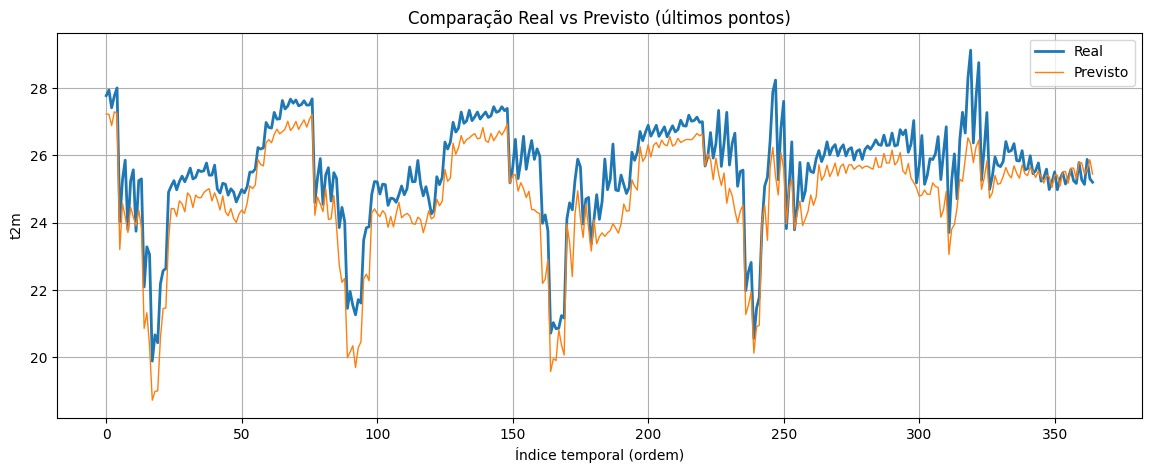

In [25]:
# Vamos mostrar um trecho temporal (por exemplo últimos N pontos) para comparar real x previsto
N = 365
plt.figure(figsize=(14,5))
plt.plot(y.values[-N:], label="Real", linewidth=2)
plt.plot(y_pred_all[-N:], label="Previsto", linewidth=1)
plt.title("Comparação Real vs Previsto (últimos pontos)")
plt.xlabel("Índice temporal (ordem)")
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()